In [1]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import cv2
import skimage
from skimage import color, restoration, exposure
from skimage.util import random_noise
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,denoise_wavelet, estimate_sigma)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

2024-02-04 21:22:10.657618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 21:22:10.657737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 21:22:10.821081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
directory = '/kaggle/input/sea-animals-image-dataste/'
name = []
img_id = []

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        if any(x in filename for x in [".jpg", ".png", ".jpeg"]):
          img_id.append(os.path.join(os.path.basename(dirname),filename))
          name.append(os.path.basename(dirname))

df = pd.DataFrame({"img_id":img_id, "name":name})
df.head()

,img_id,name
0,Penguin/13441017033_5f20afed5c_o.jpg,Penguin
1,Penguin/6814743888_d76f64e5e5_o.jpg,Penguin
2,Penguin/7678547704_88ee08ec1d_b.jpg,Penguin
3,Penguin/8474798677_0abda01a4a_o.jpg,Penguin
4,Penguin/32902414928_2e8353fa26_o.jpg,Penguin


In [3]:
classes = df["name"].unique()
df["name"].value_counts()

name
Turtle_Tortoise    1903
Jelly Fish          845
Dolphin             782
Sharks              590
Sea Urchins         579
Whale               572
Octopus             562
Puffers             531
Sea Rays            517
Nudibranchs         500
Otter               500
Corals              500
Crabs               499
Starfish            499
Lobster             499
Clams               497
Eel                 497
Fish                494
Shrimp              488
Squid               483
Penguin             482
Seahorse            478
Seal                414
Name: count, dtype: int64

Il y a 23 animaux représentés dans le dataset.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


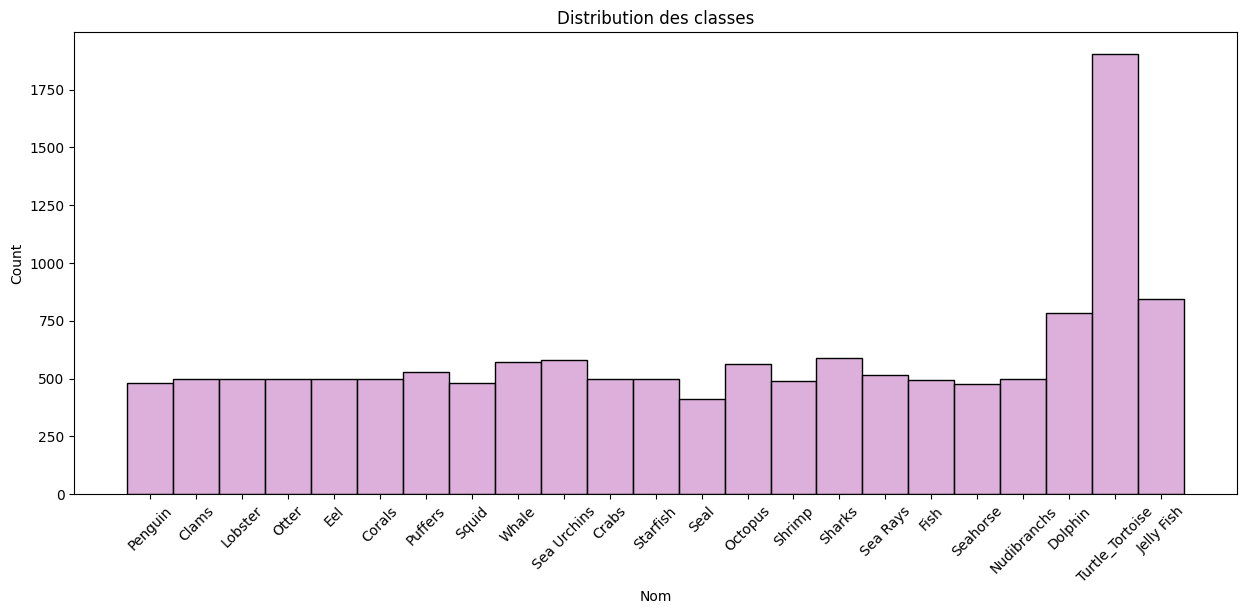

In [4]:
plt.figure(figsize=(15,6))
sns.histplot(df["name"],color="#D196D0")
plt.title("Distribution des classes")
plt.xlabel("Nom")
plt.xticks(rotation=45)
plt.show()

Il y a environ 500 images pour chaque espèce, à part pour la catégorie tortue qui contient 1900 images.

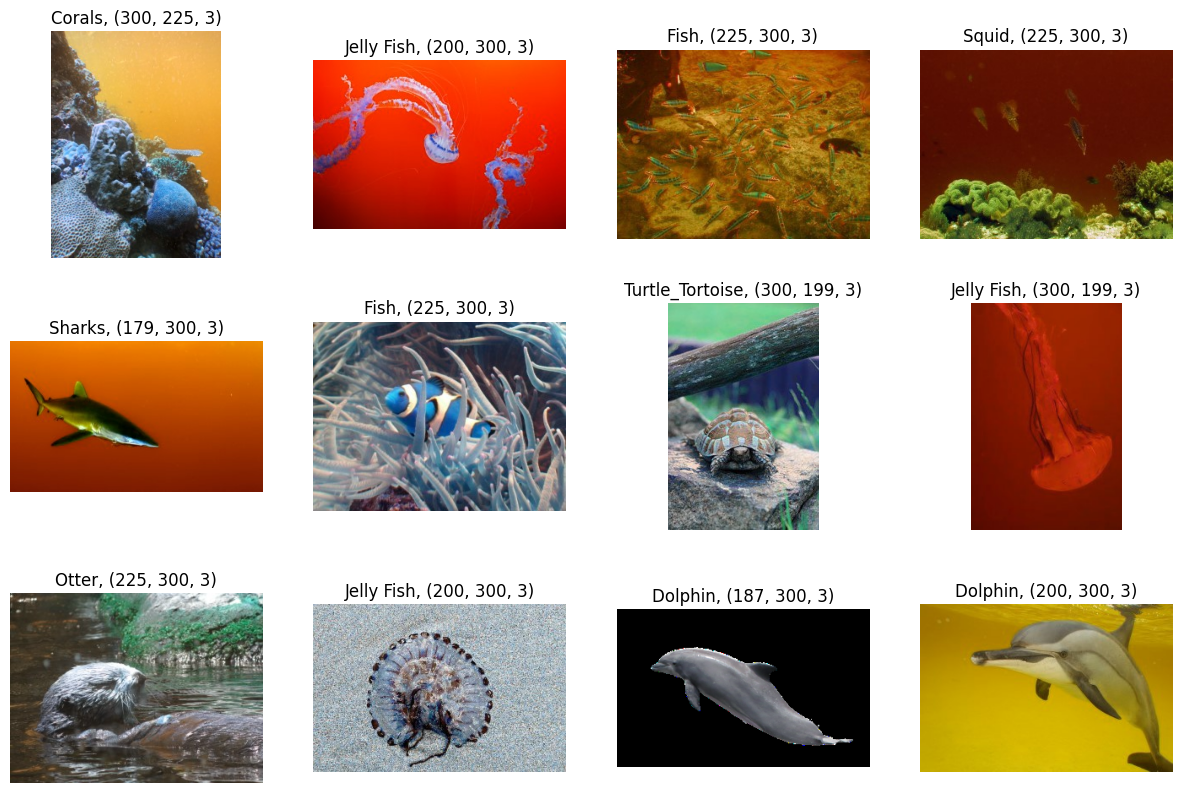

In [5]:
np.random.seed(3232)

fig,ax = plt.subplots(nrows=3,ncols=4,figsize=(15,10))

for i in range(3):
  for j in range(4):
    r = np.random.randint(0,len(df))
    img_path = directory+df["img_id"][r]
    img_name = df["name"][r]
    img = cv2.imread(img_path)

    ax[i,j].imshow(img)
    ax[i,j].set_title("{}, {}".format(img_name,img.shape))
    ax[i,j].axis("off")

plt.show()

On va ajouter un bruit gaussien aux images, ainsi que les transformer en niveaux de gris.

In [6]:
def degradation(img):
  img_gray = color.rgb2gray(img)
  img_rescaled = exposure.rescale_intensity(img_gray)
  img_noise = random_noise(img_rescaled,var=0.02**2)
  return img_noise

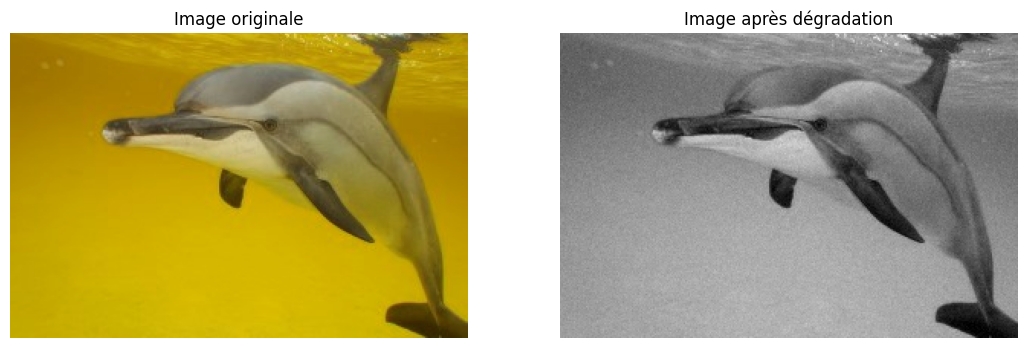

In [7]:
img_degraded = degradation(img)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,12))

ax[0].imshow(img,cmap="gray")
ax[0].set_title("Image originale")
ax[0].axis("off")

ax[1].imshow(img_degraded,cmap="gray")
ax[1].set_title("Image après dégradation")
ax[1].axis("off")

plt.show()

On va tenter de restaurer les images bruitées car lorsque l'image est bruitée le modèle a du mal à apprendre. J'ai vu cet article qui propose un modèle pour la classification d'images bruitées mais je n'ai pas encore eu le temps de l'implémenter: https://www.sciencedirect.com/science/article/pii/S2590123021000268

In [8]:
def restauration(img_noise):
    img_denoise = denoise_bilateral(img_noise, sigma_color=0.1, sigma_spatial=15,channel_axis=None)
    img_rescaled = exposure.rescale_intensity(img_denoise)
    return np.repeat(np.expand_dims(img_rescaled, axis=-1), 3, axis=-1)

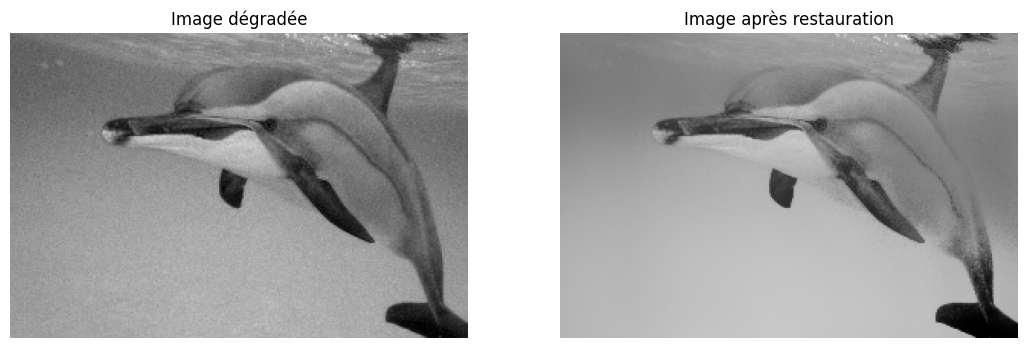

In [9]:
img_restaured = restauration(img_degraded)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,12))

ax[0].imshow(img_degraded,cmap="gray")
ax[0].set_title("Image dégradée")
ax[0].axis("off")

ax[1].imshow(img_restaured,cmap="gray")
ax[1].set_title("Image après restauration")
ax[1].axis("off")

plt.show()

In [10]:
def preprocessing(img):
    return restauration(degradation(img))

Il faudrait idéalement appliquer cette fonction à toutes les images, les sauvegarder et entrainer le modèle avec les images dégradées puis restaurées, mais les temps d'exécution sont très longs. Donc pour l'instant, on va simplement traiter les images en noir et blanc.

In [19]:
np.random.seed(87543)

df_train, df_test = train_test_split(df, test_size=0.2)

batch_size = 128
img_size = (200,200)

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    rotation_range=180,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="constant",
    preprocessing_function=tf.image.rgb_to_grayscale,
    validation_split=0.1)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.image.rgb_to_grayscale)

train_generator = train_datagen.flow_from_dataframe(
    directory=directory,
    dataframe=df_train,
    x_col = "img_id",
    y_col = "name",
    shuffle = True,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="training")

val_generator = train_datagen.flow_from_dataframe(
    directory=directory,
    dataframe=df_train,
    x_col = "img_id",
    y_col = "name",
    shuffle = True,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation")

test_generator = test_datagen.flow_from_dataframe(
    directory=directory,
    dataframe=df_test,
    x_col = "img_id",
    y_col = "name",
    target_size=img_size,
    batch_size=batch_size,
    shuffle = False,
    class_mode="categorical")

Found 9872 validated image filenames belonging to 23 classes.
Found 1096 validated image filenames belonging to 23 classes.
Found 2743 validated image filenames belonging to 23 classes.


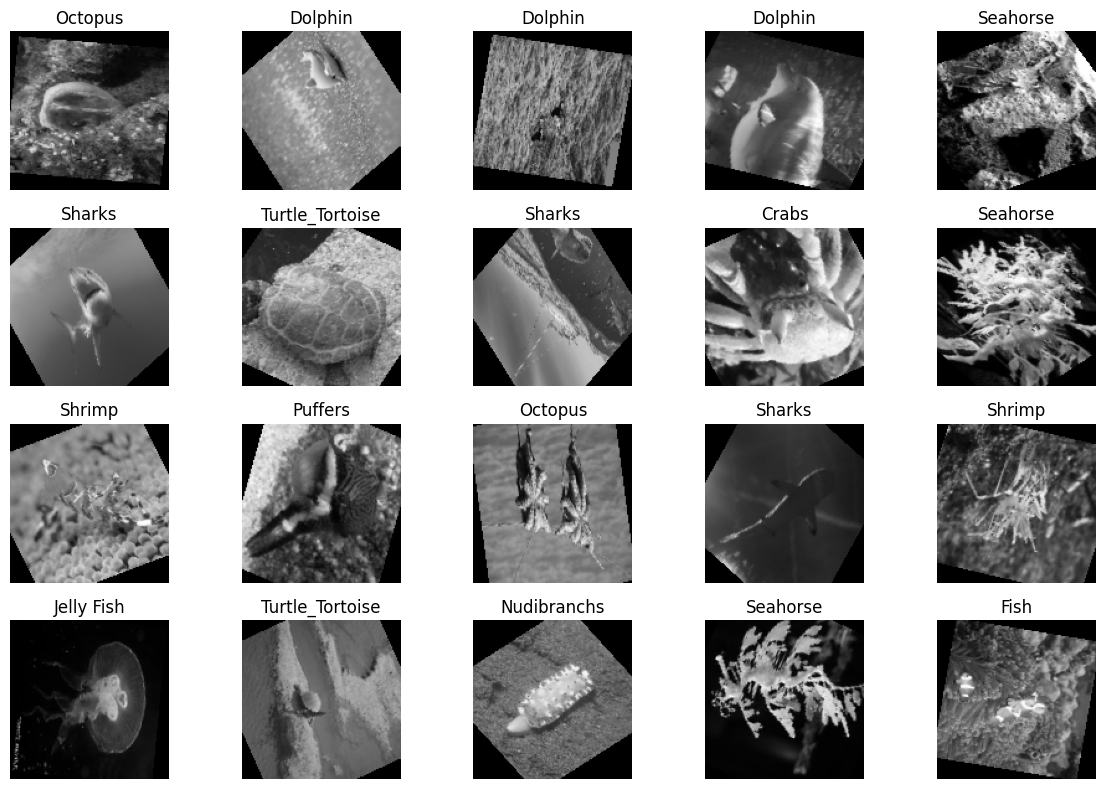

In [12]:
np.random.seed(657)

#on génère quelques images
num_batches = 1

images = []
labels = []

for i in range(num_batches):
    batch_data, batch_labels = train_generator.next()
    images.append(batch_data/255)
    labels.extend(np.argmax(batch_labels, axis=1))

images = np.concatenate(images, axis=0)
labels = np.array(labels)
classes = list(train_generator.class_indices.keys())


#on affiche quelques images
n_rows = 4
n_cols = 5

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))

#on génère un tableau d'indices sans avoir deux fois le même
R = np.random.choice(len(labels),(n_rows,n_cols),replace=False)

for i in range(n_rows):
    for j in range(n_cols):
        r = R[i,j]
        axes[i, j].imshow(images[r])
        axes[i, j].set_title(classes[labels[r]])
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [20]:
img_shape = img_size + tuple([3])

efficient_net_0 = EfficientNetV2B0(
    weights='imagenet',
    input_shape=img_shape,
    include_top=False,
    pooling='max')

model0 = Sequential()
model0.add(efficient_net_0)
model0.add(layers.Dense(23, activation='softmax'))
model0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 23)                29463     
                                                                 
Total params: 5948775 (22.69 MB)
Trainable params: 5888167 (22.46 MB)
Non-trainable params: 60608 (236.75 KB)
_________________________________________________________________


In [21]:
nb_epochs = 5

model0.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
early_stopping = EarlyStopping(monitor="val_categorical_accuracy",patience=2,restore_best_weights=True)

history0 = model0.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[early_stopping])

Epoch 1/5


2024-02-04 21:36:49.540462: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


77/77 [==============================] - 210s 2s/step - loss: 2.2320 - categorical_accuracy: 0.4519 - val_loss: 1.1856 - val_categorical_accuracy: 0.6348
Epoch 2/5
77/77 [==============================] - 173s 2s/step - loss: 1.0983 - categorical_accuracy: 0.6633 - val_loss: 0.9582 - val_categorical_accuracy: 0.7061
Epoch 3/5
77/77 [==============================] - 168s 2s/step - loss: 0.8734 - categorical_accuracy: 0.7337 - val_loss: 0.7877 - val_categorical_accuracy: 0.7686
Epoch 4/5
77/77 [==============================] - 171s 2s/step - loss: 0.8116 - categorical_accuracy: 0.7509 - val_loss: 0.7793 - val_categorical_accuracy: 0.7676
Epoch 5/5
77/77 [==============================] - 168s 2s/step - loss: 0.6686 - categorical_accuracy: 0.7961 - val_loss: 0.8055 - val_categorical_accuracy: 0.7578


On évalue les performances du modèle sur les images test, et on visualise la matrice de confusion.

In [22]:
acc0 = model0.evaluate(test_generator)[1]

22/22 [==============================] - 21s 949ms/step - loss: 1.2779 - categorical_accuracy: 0.6723


22/22 [==============================] - 18s 745ms/step


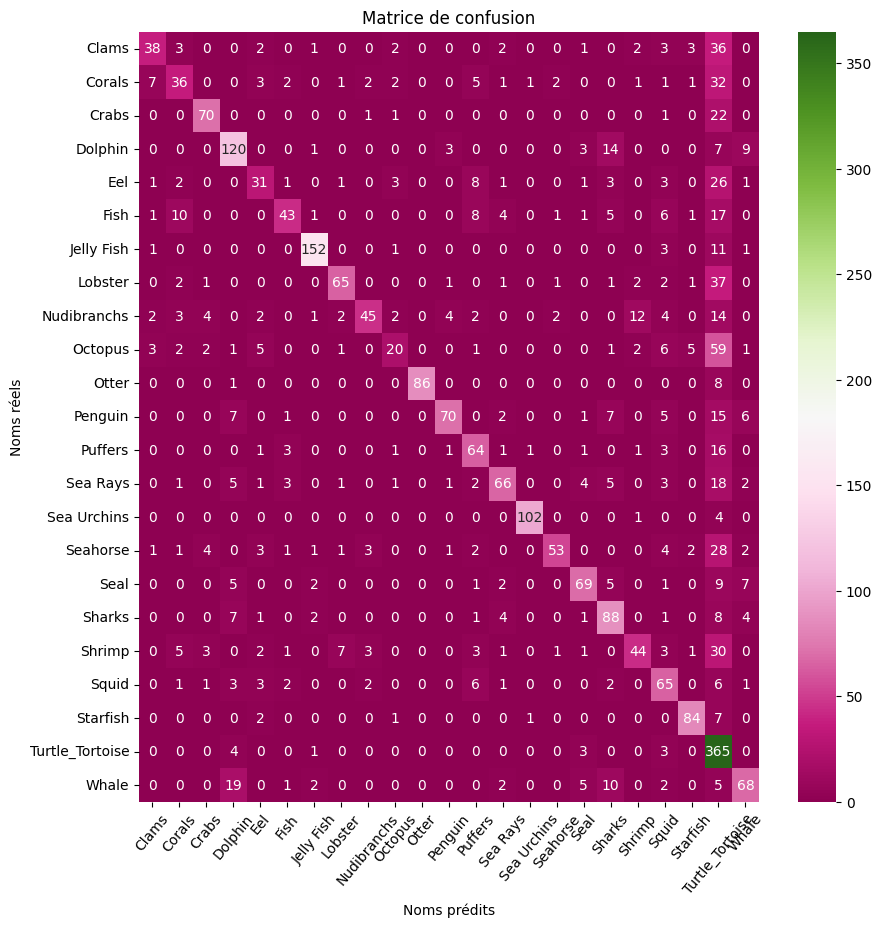

In [23]:
preds0_raw = model0.predict(test_generator)
preds0 = np.argmax(preds0_raw, axis=1)

cm = confusion_matrix(test_generator.classes,preds0)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="PiYG", xticklabels=classes, yticklabels=classes)

plt.xlabel('Noms prédits')
plt.xticks(rotation=50)
plt.ylabel('Noms réels')
plt.title("Matrice de confusion")

plt.show()

Comme on pouvait le prédire, la tortue est souvent faussement prédite. On va entrainer un autre modèle.

In [24]:
img_shape = img_size + tuple([3])

efficient_net_1 = EfficientNetV2B1(
    weights='imagenet',
    input_shape=img_shape,
    include_top=False,
    pooling='max')

model1 = Sequential()
model1.add(efficient_net_1)
model1.add(layers.Dense(23, activation='softmax'))
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b1 (Functio  (None, 1280)              6931124   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 23)                29463     
                                                                 
Total params: 6960587 (26.55 MB)
Trainable params: 6889515 (26.28 MB)
Non-trainable params: 71072 (277.62 KB)
_________________________________________________________________


In [25]:
nb_epochs = 5

model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
early_stopping = EarlyStopping(monitor="val_categorical_accuracy",patience=2,restore_best_weights=True)

history1 = model1.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[early_stopping])

Epoch 1/5


2024-02-04 21:52:32.585189: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetv2-b1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


77/77 [==============================] - 231s 2s/step - loss: 2.1126 - categorical_accuracy: 0.4721 - val_loss: 1.0226 - val_categorical_accuracy: 0.6748
Epoch 2/5
77/77 [==============================] - 184s 2s/step - loss: 1.0516 - categorical_accuracy: 0.6830 - val_loss: 0.8760 - val_categorical_accuracy: 0.7363
Epoch 3/5
77/77 [==============================] - 184s 2s/step - loss: 0.8548 - categorical_accuracy: 0.7384 - val_loss: 0.7922 - val_categorical_accuracy: 0.7549
Epoch 4/5
77/77 [==============================] - 187s 2s/step - loss: 0.7567 - categorical_accuracy: 0.7707 - val_loss: 0.7502 - val_categorical_accuracy: 0.7734
Epoch 5/5
77/77 [==============================] - 184s 2s/step - loss: 0.6689 - categorical_accuracy: 0.7998 - val_loss: 0.7819 - val_categorical_accuracy: 0.7754


In [29]:
acc1 = model1.evaluate(test_generator)[1]
preds1_raw = model1.predict(test_generator)

22/22 [==============================] - 26s 1s/step


Puis un dernier.

In [27]:
img_shape = img_size + tuple([3])

efficient_net_2 = EfficientNetV2B2(
    weights='imagenet',
    input_shape=img_shape,
    include_top=False,
    pooling='max')

model2 = Sequential()
model2.add(efficient_net_2)
model2.add(layers.Dense(23, activation='softmax'))
model2.summary()

35839040/35839040 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 23)                32407     
                                                                 
Total params: 8801781 (33.58 MB)
Trainable params: 8719493 (33.26 MB)
Non-trainable params: 82288 (321.44 KB)
_________________________________________________________________


In [28]:
nb_epochs = 5

model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
early_stopping = EarlyStopping(monitor="val_categorical_accuracy",patience=2,restore_best_weights=True)

history2 = model2.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[early_stopping])

Epoch 1/5


2024-02-04 22:09:11.844018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetv2-b2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


77/77 [==============================] - 249s 3s/step - loss: 2.0639 - categorical_accuracy: 0.4786 - val_loss: 1.0998 - val_categorical_accuracy: 0.6680
Epoch 2/5
77/77 [==============================] - 197s 3s/step - loss: 1.0378 - categorical_accuracy: 0.6904 - val_loss: 0.8210 - val_categorical_accuracy: 0.7539
Epoch 3/5
77/77 [==============================] - 203s 3s/step - loss: 0.8204 - categorical_accuracy: 0.7494 - val_loss: 0.8089 - val_categorical_accuracy: 0.7432
Epoch 4/5
77/77 [==============================] - 198s 3s/step - loss: 0.7341 - categorical_accuracy: 0.7758 - val_loss: 0.8905 - val_categorical_accuracy: 0.7363


In [30]:
acc2 = model2.evaluate(test_generator)[1]
preds2_raw = model2.predict(test_generator)

22/22 [==============================] - 22s 933ms/step


On va ensuite rassembler les prédictions faites par les 3 modèles, pondérées par la précision sur les images test.

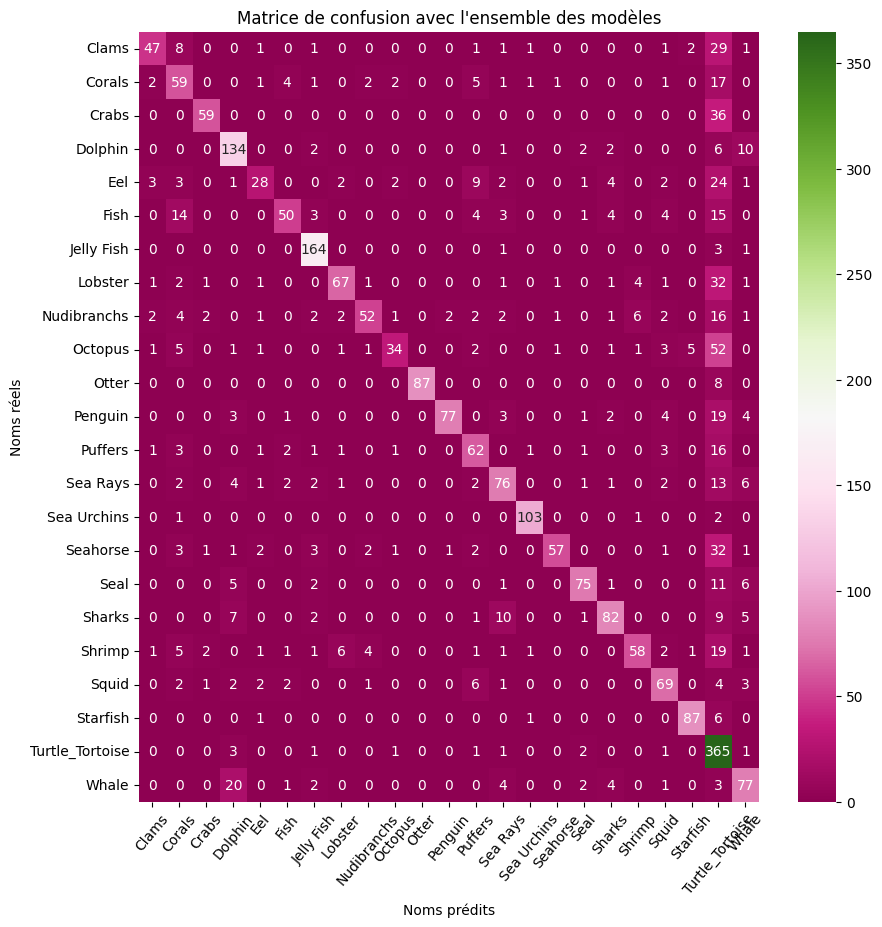

In [32]:
preds_raw_ensemble = (acc0*preds0_raw + acc1*preds1_raw + acc2*preds2_raw)/(acc0+acc1+acc2)
preds_ensemble = np.argmax(preds_raw_ensemble, axis=1)

cm = confusion_matrix(test_generator.classes,preds_ensemble)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="PiYG", xticklabels=classes, yticklabels=classes)

plt.xlabel('Noms prédits')
plt.xticks(rotation=50)
plt.ylabel('Noms réels')
plt.title("Matrice de confusion avec l'ensemble des modèles")

plt.show()

In [34]:
accuracy_score(preds_ensemble,test_generator.labels)

0.7178271965001822

On a une précision légèremment supérieure en assemblant les modèles. Il existe beaucoup d'autres méthodes pour faire des ensembles de modèles, on pourrait par exemple tester une cascade, qui accepte une valeur de sorite uniquement si celle-ci a une probabilité suffisante.

Le modèle n'est pour l'instant pas optimal, il faurdait tester différentes transformations des images initiales, différentes architectures, etc... On pourrait couper ou segmenter certaines images afin de ne pas avoir trop d'éléments gênants. On pourrait aussi couper les images contenant plusieurs fois le même animal afin d'avoir plus de données.